In [1]:
import rasterio as rio
from matplotlib import pyplot as plt
import numpy as np
from glob import glob
import os

from earthpy.spatial import stack
import xarray as xr

import pickle

# aggregating
from skimage.transform import rescale, resize, downscale_local_mean

# mapping
import cartopy
import cartopy.crs as ccrs

In [20]:
raster_folder = r"../vars/grid_0_25_degree_vars/" # data refresh!
var = 'AFC_num' # [AFC_num, AFC_perc, FRP_mean, FRP_max, FRP_total]
months = ['April', 'May', 'June', 'July', 'August', 'September', 'October', 'November']
yr_mos = ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December']
yr_mos_p1 = ['January', 'February']

# extract rasters for a single fire year, defined as March to February of following year.
year = 2012
day_files = glob(raster_folder + f'{var}/*_D_*_{year}*')
day_files = [f for f in day_files if os.path.basename(f).split('_')[4] in yr_mos]
day_files2 = glob(raster_folder + f'{var}/*_D_*_{year+1}*')
day_files2 = [f for f in day_files2 if os.path.basename(f).split('_')[4] in yr_mos_p1]
day_files_yr = day_files + day_files2
day_files_yr

[os.path.basename(f).split('_')[4] for f in day_files_yr]

['April',
 'August',
 'December',
 'July',
 'June',
 'March',
 'May',
 'November',
 'October',
 'September',
 'February',
 'January']

In [24]:
import calendar

In [67]:
cur_sort

[4, 8, 12, 7, 6, 3, 5, 11, 10, 9, 2, 1]

In [68]:
month_vals = dict((v,k) for k,v in enumerate(calendar.month_name))
month_names = [os.path.basename(f).split('_')[4] for f in day_files_yr]

# get the way things are sorted
cur_sort = [month_vals[m] for m in month_names] 
cur_sort_inds = np.array(cur_sort)

# should be sorted as 
fy_sort = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 1, 2]
fy_sort_inds = np.array(fy_sort)

cur_sort_inds, fy_sort_inds



(array([ 4,  8, 12,  7,  6,  3,  5, 11, 10,  9,  2,  1]),
 array([ 3,  4,  5,  6,  7,  8,  9, 10, 11, 12,  1,  2]))

In [69]:
import pandas as pd
temp_df = pd.DataFrame({'files': day_files_yr, 'cur_ind':cur_sort_inds, 'fy_ind': fy_sort_inds, 'dummy': 'blah'})
temp_df.head()

,cur_ind,dummy,files,fy_ind
0,4,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,3
1,8,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,4
2,12,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,5
3,7,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,6
4,6,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,7


In [75]:
# sort correctly for FY
df1 = temp_df.set_index('cur_ind')
df1 = df1.reindex(index=fy_sort_inds)
df1.reset_index()

,cur_ind,dummy,files,fy_ind
0,3,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,8
1,4,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,3
2,5,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,9
3,6,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,7
4,7,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,6
5,8,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,4
6,9,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,12
7,10,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,11
8,11,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,10
9,12,blah,../vars/grid_0_25_degree_vars/AFC_num\modis_D_...,5


In [78]:
# verify
for fi in df1.files:
    print(fi)

../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_March_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_April_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_May_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_June_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_July_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_August_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_September_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_October_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_November_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_December_2012.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_January_2013.tif
../vars/grid_0_25_degree_vars/AFC_num\modis_D_AFC_num_February_2013.tif


In [93]:
from earthpy.spatial import stack

# stack one
test_arr,_ = stack(df1.files, nodata=-32768)

# mask the nodata
ma = np.ma.masked_equal(test_arr, -32768)

# get the argmax
TODO

In [94]:
import scipy.stats

mode, ct = scipy.stats.mode(ma)


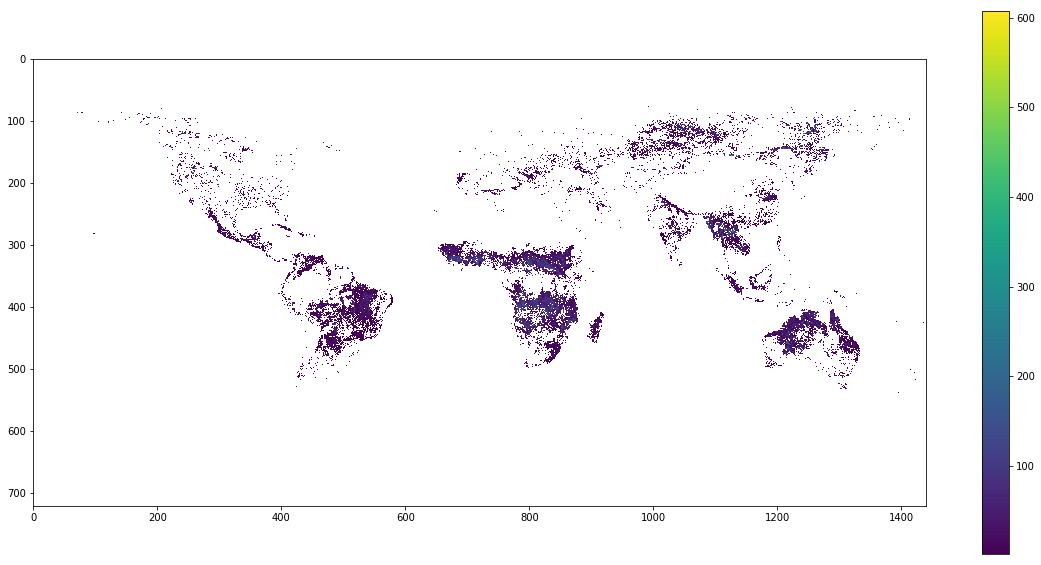

In [96]:


plt.figure(figsize=(20,10))
plt.imshow(ma.mean(axis=0));
plt.colorbar()

In [97]:
ma.max()

674.0